Suicidal Tweet Detection

In [1]:
import pandas as pd
import re
import string
import seaborn as sns

import html
import unicodedata
import emoji
import spacy
import pickle
 
nlp = spacy.load('en_core_web_sm')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Suicide_Ideation_Dataset(Twitter-based).csv")
df.head(10)

,Tweet,Suicide
0,making some lunch,Not Suicide post
1,@Alexia You want his money.,Not Suicide post
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post
5,"@ValenValdez Oh, that's good to hear. But is i...",Not Suicide post
6,@mcm180 u've got a list for fellow #hotties? Y...,Not Suicide post
7,@jakepaul @jamescharles @LoganPaul Just becaus...,Potential Suicide post
8,time for some warsaw beer garden chilling,Not Suicide post
9,I hate my life lmao I hope I die soon or sumn ...,Potential Suicide post


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787 entries, 0 to 1786
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tweet    1785 non-null   object
 1   Suicide  1787 non-null   object
dtypes: object(2)
memory usage: 28.1+ KB


In [4]:
df.shape

(1787, 2)

In [5]:
df.isnull().sum().sum()
df.dropna(inplace=True)

In [6]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [7]:
df.shape

(1777, 2)

In [8]:
df['Suicide'].value_counts()
# df['Suicide'].value_counts().plot(kind='pie',autopct='%1.1f%%')
# 63.3% and 36.7%

Suicide
Not Suicide post           1124
Potential Suicide post      653
Name: count, dtype: int64

In [9]:
df['class'] = df['Suicide'].map({"Not Suicide post":0,"Potential Suicide post ":1})
df.head()

,Tweet,Suicide,class
0,making some lunch,Not Suicide post,0
1,@Alexia You want his money.,Not Suicide post,0
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post,1
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post,0
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post,0


In [10]:
# TextBlob, stanfordnlp
manual_contr_expansions_mapping = { "ain't": "is not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "could've": "could have", "couldn't": "could not", "didn't": "did not",
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
    "how'd": "how did", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'll": "I will", "I'm": "I am", "I've": "I have", "isn't": "is not", "it'd": "it would",
    "it'll": "it will", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "must've": "must have",
    "mustn't": "must not", "needn't": "need not", "oughtn't": "ought not", "shan't": "shall not", "she'd": "she would", "she'll": "she will", "she's": "she is", "should've": "should have",
    "shouldn't": "should not", "that's": "that is", "there'd": "there would", "there's": "there is", "they'd": "they would", "they'll": "they will", "they're": "they are",
    "they've": "they have", "wasn't": "was not", "we'd": "we would", "we'll": "we will", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
    "what're": "what are", "what's": "what is", "what've": "what have", "where'd": "where did", "where's": "where is", "who'll": "who will", "who's": "who is",
    "won't": "will not", "wouldn't": "would not", "you'd": "you would", "you'll": "you will", "you're": "you are", "you've": "you have", "aint": "is not", "arent": "are not", "cant": "cannot",
    "cant've": "cannot have", "couldnt": "could not", "didnt": "did not", "doesnt": "does not", "dont": "do not", "hadnt": "had not", "hasnt": "has not", "havent": "have not",  
    "Im": "I am", "isnt": "is not", "lets": "let us", "maam": "madam", "maynt": "may not", "mightnt": "might not", "mustnt": "must not", "neednt": "need not", "oughtnt": "ought not",
    "shant": "shall not", "shouldnt": "should not", "thats": "that is", "theres": "there is",  "theyll": "they will", "theyre": "they are", "wasnt": "was not", "werent": "were not",
    "whats": "what is", "wheres": "where is", "whos": "who is", "wont": "will not", }

In [11]:
def expand_contractions(text, contraction_map):
    # Define a regex pattern for finding contractions
    pattern = re.compile('({})'.format('|'.join(contraction_map.keys())),
                         flags=re.IGNORECASE | re.DOTALL)
    
    def expand_match(contraction):
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match.lower())
        return expanded_contraction
        
    expanded_text = pattern.sub(expand_match, text)
    return expanded_text
        
def expand_contractions_in_column(df, column_name, contraction_map, new_column_name):
    df[new_column_name] = df[column_name].apply(lambda x: expand_contractions(x, contraction_map))
    return df

# Apply contraction expansion to 'tweet' column and store in 'expanded_tweet' column
df = expand_contractions_in_column(df, 'Tweet', manual_contr_expansions_mapping, 'expanded_tweet')

In [12]:
PUNC = string.punctuation
 
def clean_text(text):
    
    # lowercase
    text = str(text).lower()
    # remove quotation "" which is encoded as &quot;
    text = html.unescape(text)
    # remove HTML tags
    text = re.sub(r'<.*?>+', '',text)
    # remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # remove numbers
    text = re.sub(r'\d', '',text)
    # remove punctuations
    text = re.sub('[%s]' % re.escape(PUNC), '',text)
    # remove extra spaces
    text = re.sub(' +', ' ', text)
    # remove 'rt' which indicates retweets
    text = re.sub('rt', '',text)   
    
    return text
 
df['Tweet'] = df['expanded_tweet'].apply(clean_text)
df['Tweet'][20]

'sadegsigerrusengi want to die so much i do not want to be here anymore'

In [13]:
def clean_text(text):
    cleaned_text = []
    for char in text:
        if unicodedata.category(char)[0] in {'P', 'Z'}:
            # Replace punctuation and separators with space
            cleaned_text.append(' ')
        elif emoji.demojize(char) != char:
            # Convert emoji to descriptive text with space
            emoji_desc = emoji.demojize(char).replace(":", " ")
            # print(emoji_desc)
            cleaned_text.append(f" {emoji_desc} ")
        else:
            # Keep printable characters
            cleaned_text.append(char)
    cleaned_text = ''.join(cleaned_text).strip()  # Join and strip leading/trailing spaces
    return cleaned_text

In [14]:
# Additional processing: encode and decode, then remove extra spaces
df['cleaned_tweet'] = df['Tweet'].apply(lambda x: x.encode('latin-1', 'ignore').decode('utf-8', 'ignore'))
 
# Apply clean_text function to tweet column
df['cleaned_tweet'] = df['cleaned_tweet'].apply(clean_text)
df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: re.sub(' +', ' ', x))
 
# Display the cleaned tweets
print(df['cleaned_tweet'][21])

and i hate the fact if it is true dojae will do surgery dojae has to endure the pain alone without segye loudly_crying_face loudly_crying_face loudly_crying_face loudly_crying_face a


In [15]:
# negations
def manage_negations(text):
    
    # Replace 'not' and 'no' followed by a token with 'not_' + token or 'no_' + token
    negation_pattern = re.compile(r'\b(not|no)\s+(?=\w)', flags=re.IGNORECASE)
    text = negation_pattern.sub(lambda x: x.group(0).replace(' ', '_'), text)
    return text
 
df['managed_tweet'] = df['cleaned_tweet'].apply(manage_negations)
print(df['managed_tweet'].iloc[21])

and i hate the fact if it is true dojae will do surgery dojae has to endure the pain alone without segye loudly_crying_face loudly_crying_face loudly_crying_face loudly_crying_face a


In [16]:
# Tokenize, remove stopwords, and lemmatize using spaCy
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return tokens
 
# Apply preprocessing function to each tweet text
df['Processed_Tweet'] = df['managed_tweet'].apply(preprocess_text)
df['Processed_Tweet'] = df['Processed_Tweet'].apply(lambda x: ' '.join(x))
 
# Print the processed tokens for each tweet
for i, tokens in enumerate(df['Processed_Tweet']):
    print(f"Tweet {i+1} tokens:", tokens)

Tweet 1 tokens: make lunch
Tweet 2 tokens: alexia want money
Tweet 3 tokens: dizzyhrvy crap take forever m go sleep day
Tweet 4 tokens: jnaylor kiwitweets hey jer sta twitter
Tweet 5 tokens: try delicious library mixed result bar code think want add spo bra instead drill cool app tho
Tweet 6 tokens: valenvaldez oh good hear continue holy week
Tweet 7 tokens: mcm uve get list fellow hottie go to share amigo
Tweet 8 tokens: jakepaul jamescharle loganpaul shane series not_mean people seriously y
Tweet 9 tokens: te warsaw beer garden chilling
Tweet 10 tokens: hate life lmao hope die soon sumn tired
Tweet 11 tokens: lover survival mother survival
Tweet 12 tokens: stray cat campus look like garfield student feed h fat like
Tweet 13 tokens: 
Tweet 14 tokens: awful habit avoid write paper watch instagram live video kid nanny
Tweet 15 tokens: rivensky haha not_have file rest away delete
Tweet 16 tokens: turbizzle goooooood hwore
Tweet 17 tokens: akwesiquan aneesay want ill active not_quite sure

In [17]:
df.head()

,Tweet,Suicide,class,expanded_tweet,cleaned_tweet,managed_tweet,Processed_Tweet
0,making some lunch,Not Suicide post,0,making some lunch,making some lunch,making some lunch,make lunch
1,alexia you want his money,Not Suicide post,0,@Alexia You want his money.,alexia you want his money,alexia you want his money,alexia want money
2,dizzyhrvy that crap took me forever to put tog...,Potential Suicide post,1,@dizzyhrvy that crap took me forever to put to...,dizzyhrvy that crap took me forever to put tog...,dizzyhrvy that crap took me forever to put tog...,dizzyhrvy crap take forever m go sleep day
3,jnaylor kiwitweets hey jer since when did you ...,Not Suicide post,0,@jnaylor #kiwitweets Hey Jer! Since when did y...,jnaylor kiwitweets hey jer since when did you ...,jnaylor kiwitweets hey jer since when did you ...,jnaylor kiwitweets hey jer sta twitter
4,trying out delicious library with mixed result...,Not Suicide post,0,Trying out &quot;Delicious Library 2&quot; wit...,trying out delicious library with mixed result...,trying out delicious library with mixed result...,try delicious library mixed result bar code th...


In [18]:
X_train, X_test, y_train, y_test = train_test_split(df['Processed_Tweet'], df['class'], test_size=0.2, random_state=42)

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  
 
# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
 
# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

As 'MultinomialNB' doesn't provide class_weight method, hence applied SMOTE to balance the data.

In [19]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

In [20]:
# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'SVC': SVC(),
    'Naive Bayes': MultinomialNB(),
    'Random Forest Classifier': RandomForestClassifier()
}
 
# Train and evaluate each classifier
for clf_name, clf in classifiers.items():
    clf.fit(X_train_smote, y_train_smote)
    y_pred = clf.predict(X_test_tfidf)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Classifier: {clf_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)
    print("--------------------------")

Classifier: Logistic Regression
Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       211
           1       0.87      0.83      0.85       145

    accuracy                           0.88       356
   macro avg       0.88      0.87      0.88       356
weighted avg       0.88      0.88      0.88       356

--------------------------
Classifier: Decision Tree Classifier
Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       211
           1       0.83      0.83      0.83       145

    accuracy                           0.86       356
   macro avg       0.85      0.85      0.85       356
weighted avg       0.86      0.86      0.86       356

--------------------------
Classifier: SVC
Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95     

In [21]:
# Define parameter grids for each classifier
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],  # Regularization parameter
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [100, 200, 300]
    },
    'Decision Tree Classifier': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVC': {
        'C': [0.1, 1, 10, 100],     # Regularization parameter
        'gamma': ['scale', 'auto'], # Kernel coefficient
        'kernel': ['linear', 'rbf'] # Kernel type
    },
    'Naive Bayes': {
        'alpha': [0.1, 0.5, 1.0, 2.0],  # Additive smoothing parameter
    },
    'Random Forest Classifier': {
        'n_estimators': [100, 200, 300],    
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}
 
# Create empty dictionary to store best models
best_models = {}
 
# Iterate over classifiers
for clf_name, clf in classifiers.items():

    # Instantiate GridSearchCV
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grids[clf_name], cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    
    # Fit GridSearchCV
    grid_search.fit(X_train_tfidf, y_train)
    
    # Print best parameters and best score
    print("Best parameters for {}: {}".format(clf_name, grid_search.best_params_))
    print("Best cross-validation accuracy for {}: {:.2f}".format(clf_name, grid_search.best_score_))
    
    # Save best model
    best_models[clf_name] = grid_search.best_estimator_
    
    # Evaluate the best model on test data
    y_pred = grid_search.best_estimator_.predict(X_test_tfidf)
    print("\nTest set classification report for {}:".format(clf_name))
    print(classification_report(y_test, y_pred))
    print("\n")
 
# accessing the best model
best_model = best_models['Random Forest Classifier']

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for Logistic Regression: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}
Best cross-validation accuracy for Logistic Regression: 0.91

Test set classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       211
           1       0.91      0.79      0.85       145

    accuracy                           0.88       356
   macro avg       0.89      0.87      0.88       356
weighted avg       0.89      0.88      0.88       356



Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Decision Tree Classifier: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best cross-validation accuracy for Decision Tree Classifier: 0.90

Test set classification report for Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89 

Interpretation:
- All classifiers (Logistic Regression, Decision Tree, SVC, and Random Forest) perform relatively well with similar cross-validation accuracies around 0.90.
 
- The Random Forest Classifier slightly outperforms the others on the test set with an accuracy of 0.89 and validation set with an accuracy of 0.89 and balanced performance in precision, recall, and F1-score for both classes.

<Axes: >

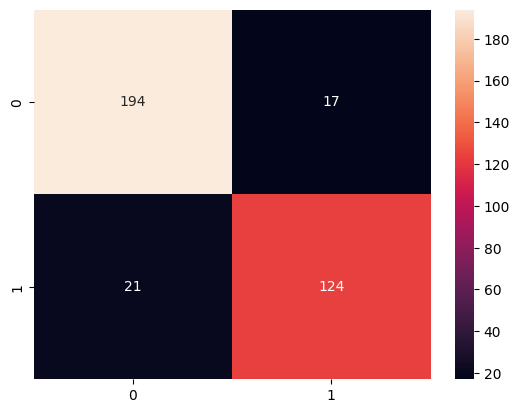

In [22]:
y_pred = best_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt='d')

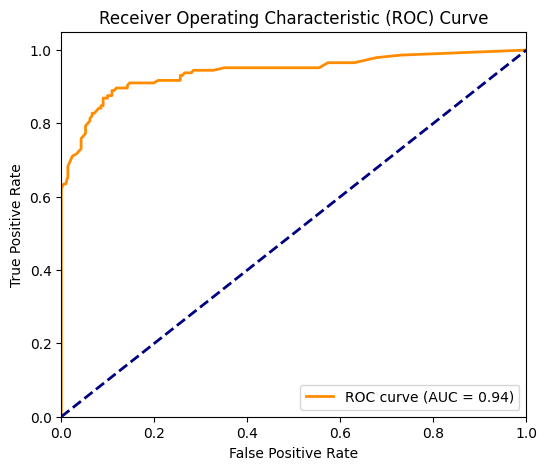

In [23]:
# Predict probabilities
y_proba = clf.predict_proba(X_test_tfidf)[:, 1]
 
# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
 
# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [24]:
with open('model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [25]:
df.to_csv("cleaned_data.csv")